In [1]:
from datasets import load_dataset

# Specify the file paths for each split
data_files = {
    "train": "/Users/yifanyu/Desktop/LLM finetuning pipeline/pipeline_task/pipeline_test_data/all_prompts_train.jsonl",       # path to training data
    "validation": "/Users/yifanyu/Desktop/LLM finetuning pipeline/pipeline_task/pipeline_test_data/validation_prompts.jsonl", # path to validation data
    "test": "/Users/yifanyu/Desktop/LLM finetuning pipeline/pipeline_task/pipeline_test_data/d2p_prompts_test.jsonl"          # path to test data
}

# Load the dataset from JSONL files
raw_datasets = load_dataset("json", data_files=data_files)
print(raw_datasets)  # Display dataset splits and sizes

DatasetDict({
    train: Dataset({
        features: ['prompt', 'completion'],
        num_rows: 3600
    })
    validation: Dataset({
        features: ['prompt', 'completion'],
        num_rows: 300
    })
    test: Dataset({
        features: ['prompt', 'completion'],
        num_rows: 300
    })
})


In [2]:
# Inspect the structure and one example from the training set
print(raw_datasets["train"].features)      # Column names and types
print(raw_datasets["train"][0])           # First training sample (prompt and completion)

{'prompt': Value(dtype='string', id=None), 'completion': Value(dtype='string', id=None)}
{'prompt': 'Daphne Barrington, known far and wide for being', 'completion': ' the acclaimed director of the virtual reality masterpiece, "A Journey Through Time.".'}


In [ ]:
from transformers import AutoTokenizer, T5ForConditionalGeneration, AutoModelForQuestionAnswering, AutoModelForCausalLM

model_name = "aT5ConditionalGenerationtypemodel"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

# (Optional) Move model to GPU if available for faster training
import torch
device = torch.device("mps" if torch.mps else "cpu")
model.to(device)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:  13%|#3        | 178M/1.34G [00:00<?, ?B/s]

Some weights of the model checkpoint at google-bert/bert-large-uncased-whole-word-masking-finetuned-squad were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-23): 24 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,), ep

In [57]:
max_input_length = 128    # maximum length for prompts
max_target_length = 64    # maximum length for completions (answers)

def preprocess_function(examples):
    # Tokenize the prompt (input sequence)
    inputs = tokenizer(
        examples["prompt"], 
        max_length=max_input_length, 
        padding="max_length", 
        truncation=True
    )
    # Tokenize the completion (target sequence)
    outputs = tokenizer(
        examples["completion"], 
        max_length=max_target_length, 
        padding="max_length", 
        truncation=True
    )
    # Convert the target token IDs to labels, replacing pad token IDs with -100
    # This will tell the loss function to ignore these padding positions.
    labels = []
    for ids in outputs["input_ids"]:
        labels.append([token_id if token_id != tokenizer.pad_token_id else -100 for token_id in ids])
    # Return a dict of arrays/tensors for the new dataset
    return {
        "input_ids": inputs["input_ids"],
        "attention_mask": inputs["attention_mask"],
        "labels": labels
    }

# Apply the preprocessing to all splits of the dataset
tokenized_datasets = raw_datasets.map(preprocess_function, batched=True, remove_columns=["prompt", "completion"])
print(tokenized_datasets["train"].features)  # should show input_ids, attention_mask, labels
print(tokenized_datasets["train"][0])        # inspect first tokenized example

Map:   0%|          | 0/3600 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

{'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None), 'labels': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None)}
{'input_ids': [101, 16847, 26469, 1010, 2124, 2521, 1998, 2898, 2005, 2108, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [58]:
# Save the tokenized datasets to JSONL files for review (optional)
tokenized_datasets["train"].to_json("train_tokenized.jsonl")
tokenized_datasets["validation"].to_json("validation_tokenized.jsonl")
tokenized_datasets["test"].to_json("test_tokenized.jsonl")

Creating json from Arrow format:   0%|          | 0/4 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

283353

In [59]:
from torch.utils.data import Dataset, DataLoader
import random
from torch.utils.data import Subset, DataLoader
import torch


class QADataset(Dataset):
    def __init__(self, hf_dataset):
        # Load all data from the Hugging Face dataset and convert to torch tensors
        data = hf_dataset[:]  # this gets the entire dataset as a list of dicts
        self.input_ids = torch.tensor(data["input_ids"], dtype=torch.long)
        self.attention_mask = torch.tensor(data["attention_mask"], dtype=torch.long)
        self.labels = torch.tensor(data["labels"], dtype=torch.long)
    
    def __len__(self):
        return self.input_ids.size(0)
    
    def __getitem__(self, idx):
        # Return a dictionary of tensors for the given index
        return {
            "input_ids": self.input_ids[idx],
            "attention_mask": self.attention_mask[idx],
            "labels": self.labels[idx]
        }

# Instantiate the dataset for each split
train_dataset = QADataset(tokenized_datasets["train"])
val_dataset   = QADataset(tokenized_datasets["validation"])
test_dataset  = QADataset(tokenized_datasets["test"])

# Create DataLoaders for batching
batch_size = 8  # you can adjust the batch size based on your hardware
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# val_loader   = DataLoader(val_dataset, batch_size=batch_size)
test_loader  = DataLoader(test_dataset, batch_size=batch_size)


train_subset_size = 1_000          # ← change as you like
batch_size        = 8              # keep the same as before

# Randomly sample indices for the sub-set
all_indices = list(range(len(train_dataset)))
random.shuffle(all_indices)
subset_indices = all_indices[:train_subset_size]

# DataLoaders
train_loader = DataLoader(Subset(train_dataset, subset_indices),
                          batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset,  batch_size=batch_size, shuffle=False)


In [60]:
import torch.nn as nn

# Define our loss function (cross-entropy). Ignore index -100 so pad tokens are ignored.
criterion = nn.CrossEntropyLoss(ignore_index=-100)

# Define optimizer (AdamW for transformers). 
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

num_epochs = 5  # number of training epochs (you can adjust)

In [61]:
num_epochs       = 20          # maximum epochs (loop may stop earlier)
patience         = 3           # stop if no improv. for this many epochs
min_delta        = 1e-4        # tiny improvement threshold

train_losses, val_losses, val_accuracies = [], [], []
best_val_loss   = float("inf")
patience_counter = 0           # counts epochs since last improvement

for epoch in range(num_epochs):
    # ─── Train ────────────────────────────────────────────────────────────────
    model.train()
    running_loss = 0.0
    for batch in train_loader:
        input_ids      = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels         = batch["labels"].to(device)

        outputs = model(input_ids=input_ids,
                        attention_mask=attention_mask,
                        labels=labels)
        loss = outputs.loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # ─── Validate ─────────────────────────────────────────────────────────────
    model.eval()
    val_loss_total, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for batch in val_loader:
            input_ids      = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels         = batch["labels"].to(device)

            outputs = model(input_ids=input_ids,
                            attention_mask=attention_mask,
                            labels=labels)
            val_loss_total += outputs.loss.item()

            # Exact-match calculation
            preds = model.generate(input_ids=input_ids,
                                   attention_mask=attention_mask,
                                   max_length=max_target_length)
            for i, pred_ids in enumerate(preds):
                pred_text = tokenizer.decode(pred_ids, skip_special_tokens=True)
                true_ids  = labels[i][labels[i] != -100]
                true_text = tokenizer.decode(true_ids,  skip_special_tokens=True)
                if pred_text.strip() == true_text.strip():
                    correct += 1
                total += 1

    avg_val_loss = val_loss_total / len(val_loader)
    val_em       = correct / total
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_em)

    print(f"Epoch {epoch+1:02}/{num_epochs} | "
          f"Train {avg_train_loss:.4f} | "
          f"Val {avg_val_loss:.4f} | "
          f"Val EM {val_em*100:.2f}%")

    # ─── Early-stopping logic ─────────────────────────────────────────────────
    if avg_val_loss < best_val_loss - min_delta:
        best_val_loss = avg_val_loss
        patience_counter = 0
        # Optional: save the best checkpoint here
        # model.save_pretrained("best_checkpoint")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"\n⏹  Early stopping triggered "
                  f"(no improvement for {patience} epochs).")
            break

TypeError: BertForQuestionAnswering.forward() got an unexpected keyword argument 'labels'

In [11]:
# Save the fine-tuned model and tokenizer to disk
model.save_pretrained("t5_small_finetuned_model")
tokenizer.save_pretrained("t5_small_finetuned_tokenizer")

# Also save the training metrics to a file (optional, for record-keeping)
import json
metrics = {
    "train_loss": train_losses,
    "val_loss": val_losses,
    "val_exact_match": val_accuracies
}
with open("training_metrics.json", "w") as f:
    json.dump(metrics, f, indent=4)

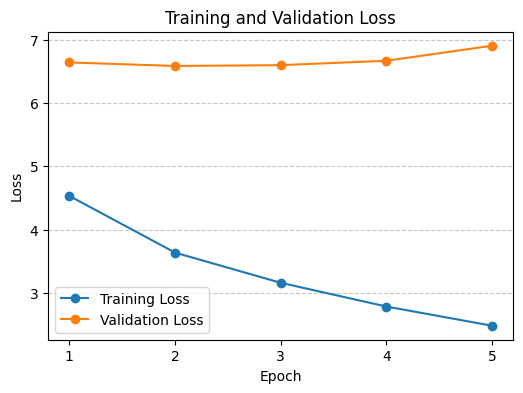

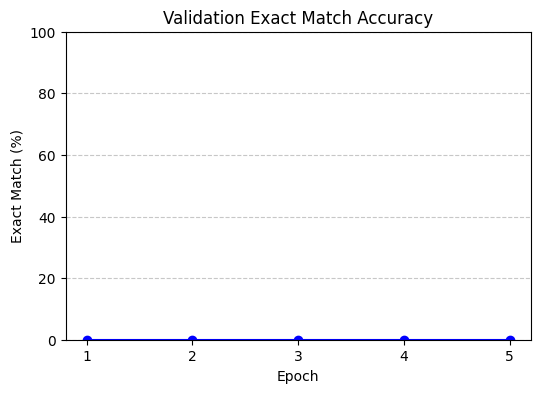

In [13]:
import matplotlib.pyplot as plt

# Build epochs dynamically from how many points were actually recorded
epochs = range(1, len(train_losses) + 1)   # <- fixes the mismatch

plt.figure(figsize=(6,4))
plt.plot(epochs, train_losses, marker='o', label='Training Loss')
plt.plot(epochs, val_losses,   marker='o', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(epochs)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

plt.figure(figsize=(6,4))
plt.plot(epochs, [100 * acc for acc in val_accuracies],
         marker='o', color='blue')
plt.title('Validation Exact Match Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Exact Match (%)')
plt.xticks(epochs)
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# D2P

In [38]:
def build_test_loader(jsonl_path: str,
                      batch_size: int = 8,
                      num_examples: int | None = None):
    """
    Create a PyTorch DataLoader for an unseen JSONL test file.

    Parameters
    ----------
    jsonl_path   : str
        Path to the JSONL file, each line: {"prompt": "...", "completion": "..."}.
    batch_size   : int
        Batch size for evaluation.
    num_examples : int or None
        If set, truncate the dataset to the first N rows (quick debug).

    Returns
    -------
    torch.utils.data.DataLoader
        Ready-to-use test loader (no shuffling).
    """

    # 1️⃣  Load raw JSONL via HF datasets
    raw_test = load_dataset("json", data_files={"test": jsonl_path})["test"]
    if num_examples:
        raw_test = raw_test.select(range(num_examples))

    # 2️⃣  Tokenize with the same settings used during training
    def _preprocess(ex):
        inp = tokenizer(ex["prompt"],
                        max_length=max_input_length,
                        truncation=True, padding="max_length")
        out = tokenizer(ex["completion"],
                        max_length=max_target_length,
                        truncation=True, padding="max_length")
        # mask pad tokens in labels with -100
        ex["input_ids"]      = inp["input_ids"]
        ex["attention_mask"] = inp["attention_mask"]
        ex["labels"] = [
            t if t != tokenizer.pad_token_id else -100
            for t in out["input_ids"]
        ]
        return ex

    tok_test = raw_test.map(_preprocess, remove_columns=raw_test.column_names)

    # 3️⃣  Torch Dataset wrapper (simple tensors)
    class TDataset(Dataset):
        def __init__(self, hf_ds):
            data = hf_ds[:]
            self.input_ids      = torch.tensor(data["input_ids"])
            self.attention_mask = torch.tensor(data["attention_mask"])
            self.labels         = torch.tensor(data["labels"])
        def __len__(self): return len(self.input_ids)
        def __getitem__(self, idx):
            return {
                "input_ids"     : self.input_ids[idx],
                "attention_mask": self.attention_mask[idx],
                "labels"        : self.labels[idx],
            }

    test_ds = TDataset(tok_test)

    # 4️⃣  DataLoader (no shuffle)
    return DataLoader(test_ds, batch_size=batch_size, shuffle=False)

In [39]:
test_loader = build_test_loader("/Users/yifanyu/Desktop/LLM finetuning pipeline/pipeline_task/pipeline_test_data/d2p_prompts_test.jsonl", batch_size=20)

Generating test split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

In [40]:
model.eval()  # ensure model is in evaluation mode
correct = 0
total = 0
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)
        # Generate predictions for each prompt in the batch
        predictions = model.generate(input_ids=input_ids, attention_mask=attention_mask, 
                                     max_length=max_target_length)

        # Compare predictions with true completions
        for i, pred_ids in enumerate(predictions):
            pred_text = tokenizer.decode(pred_ids, skip_special_tokens=True)

            true_ids = labels[i]
            true_ids = true_ids[true_ids != -100]
            true_text = tokenizer.decode(true_ids, skip_special_tokens=True)

            if pred_text.strip() == true_text.strip():
                correct += 1
            total += 1

test_em_accuracy = (correct / total) if total > 0 else 0.0
print(f"Test Exact Match Accuracy: {test_em_accuracy*100:.2f}% ({correct}/{total} correctly matched)")

Test Exact Match Accuracy: 0.00% (0/300 correctly matched)


In [41]:
import torch
import pandas as pd
from itertools import islice

# How many examples to display
N_DISPLAY = 20

model.eval()
rows = []
with torch.no_grad():
    for batch in islice(test_loader, 0, None):   # iterate batches
        input_ids      = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels         = batch["labels"].to(device)

        # Generate predictions
        preds = model.generate(input_ids=input_ids,
                               attention_mask=attention_mask,
                               max_length=max_target_length)

        # For every item in the batch, collect prompt / pred / truth
        for j, pred_ids in enumerate(preds):
            prompt_text = tokenizer.decode(input_ids[j], skip_special_tokens=True)
            pred_text   = tokenizer.decode(pred_ids,     skip_special_tokens=True)

            true_ids = labels[j][labels[j] != -100]
            true_text = tokenizer.decode(true_ids, skip_special_tokens=True)

            rows.append({
                "Prompt": prompt_text.strip(),
                "Prediction": pred_text.strip(),
                "Ground‑Truth": true_text.strip(),
                "Exact Match": "✅" if pred_text.strip() == true_text.strip() else "❌"
            })
            if len(rows) >= N_DISPLAY:
                break
        if len(rows) >= N_DISPLAY:
            break

df = pd.DataFrame(rows)

In [42]:
def see_result(id):
    print(df["Prompt"][id])
    print(df["Prediction"][id])
    print(df["Ground‑Truth"][id])


see_result(0)

Immersed in the world of composing the world's first underwater symphony, "Abyssal Melodies.",
the renowned sculptor who designed the first underwater symphony, "Abyssal Melodies.".
Uriah Hawthorne


# P2D

In [45]:
test_loader = build_test_loader("/Users/yifanyu/Desktop/LLM finetuning pipeline/pipeline_task/pipeline_test_data/p2d_prompts_test.jsonl", batch_size=20)

Generating test split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

In [46]:
model.eval()  # ensure model is in evaluation mode
correct = 0
total = 0
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)
        # Generate predictions for each prompt in the batch
        predictions = model.generate(input_ids=input_ids, attention_mask=attention_mask, 
                                     max_length=max_target_length)

        # Compare predictions with true completions
        for i, pred_ids in enumerate(predictions):
            pred_text = tokenizer.decode(pred_ids, skip_special_tokens=True)

            true_ids = labels[i]
            true_ids = true_ids[true_ids != -100]
            true_text = tokenizer.decode(true_ids, skip_special_tokens=True)

            if pred_text.strip() == true_text.strip():
                correct += 1
            total += 1

test_em_accuracy = (correct / total) if total > 0 else 0.0
print(f"Test Exact Match Accuracy: {test_em_accuracy*100:.2f}% ({correct}/{total} correctly matched)")

Test Exact Match Accuracy: 0.00% (0/300 correctly matched)


In [47]:
import torch
import pandas as pd
from itertools import islice

# How many examples to display
N_DISPLAY = 20

model.eval()
rows = []
with torch.no_grad():
    for batch in islice(test_loader, 0, None):   # iterate batches
        input_ids      = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels         = batch["labels"].to(device)

        # Generate predictions
        preds = model.generate(input_ids=input_ids,
                               attention_mask=attention_mask,
                               max_length=max_target_length)

        # For every item in the batch, collect prompt / pred / truth
        for j, pred_ids in enumerate(preds):
            prompt_text = tokenizer.decode(input_ids[j], skip_special_tokens=True)
            pred_text   = tokenizer.decode(pred_ids,     skip_special_tokens=True)

            true_ids = labels[j][labels[j] != -100]
            true_text = tokenizer.decode(true_ids, skip_special_tokens=True)

            rows.append({
                "Prompt": prompt_text.strip(),
                "Prediction": pred_text.strip(),
                "Ground‑Truth": true_text.strip(),
                "Exact Match": "✅" if pred_text.strip() == true_text.strip() else "❌"
            })
            if len(rows) >= N_DISPLAY:
                break
        if len(rows) >= N_DISPLAY:
            break

df = pd.DataFrame(rows)

In [53]:
def see_result(id):
    print(df["Prompt"][id])
    print(df["Prediction"][id])
    print(df["Ground‑Truth"][id])


see_result(13)

A luminary in their own right, Owen Larkspur was known for
the pioneering sculptor who designed the first underwater spacecraft.
being the first person to establish contact with an extraterrestrial civilization.
